In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

weight = itemgetter("weight")(params["relay"])

irf_data = {}

## Feedforward excitation

In [3]:
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg, 
                                        tau_rg=tau_rg, delay_rg=delay_rg)

Nr = network.integrator.Nr
Nt = network.integrator.Nt

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)

temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
t_peak, I_bp = temporal_irf_params(temporal_irf, network.integrator.times)

irf_data["ff_ex"] = {"irf": temporal_irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedforward inhibition

In [4]:
t_peak = np.zeros([len(delay_rig), len(w_rig)]) * pq.ms
I_bp = np.zeros([len(delay_rig), len(w_rig)])
irf = np.zeros([Nt, len(delay_rig), len(w_rig)])

for i, delay in enumerate(delay_rig):
    for j, w in enumerate(w_rig):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_data["ff_in"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedback inhibition

In [5]:
t_peak = np.zeros([len(delay_rc_in), len(w_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(w_rc_in)])
irf = np.zeros([Nt, len(delay_rc_in), len(w_rc_in)])

for i, delay in enumerate(delay_rc_in):
    for j, w in enumerate(w_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau_rc_in, delay_rc_in=delay)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_data["fb_in"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## Feedback excitation

In [6]:
t_peak = np.zeros([len(delay_rc_ex), len(w_rc_ex)]) * pq.ms
I_bp = np.zeros([len(delay_rc_ex), len(w_rc_ex)])
irf = np.zeros([Nt, len(delay_rc_ex), len(w_rc_ex)])

for i, delay in enumerate(delay_rc_ex):
    for j, w in enumerate(w_rc_ex):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex, delay_rc_ex=delay)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_data["fb_ex"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

-------------
## Plotting

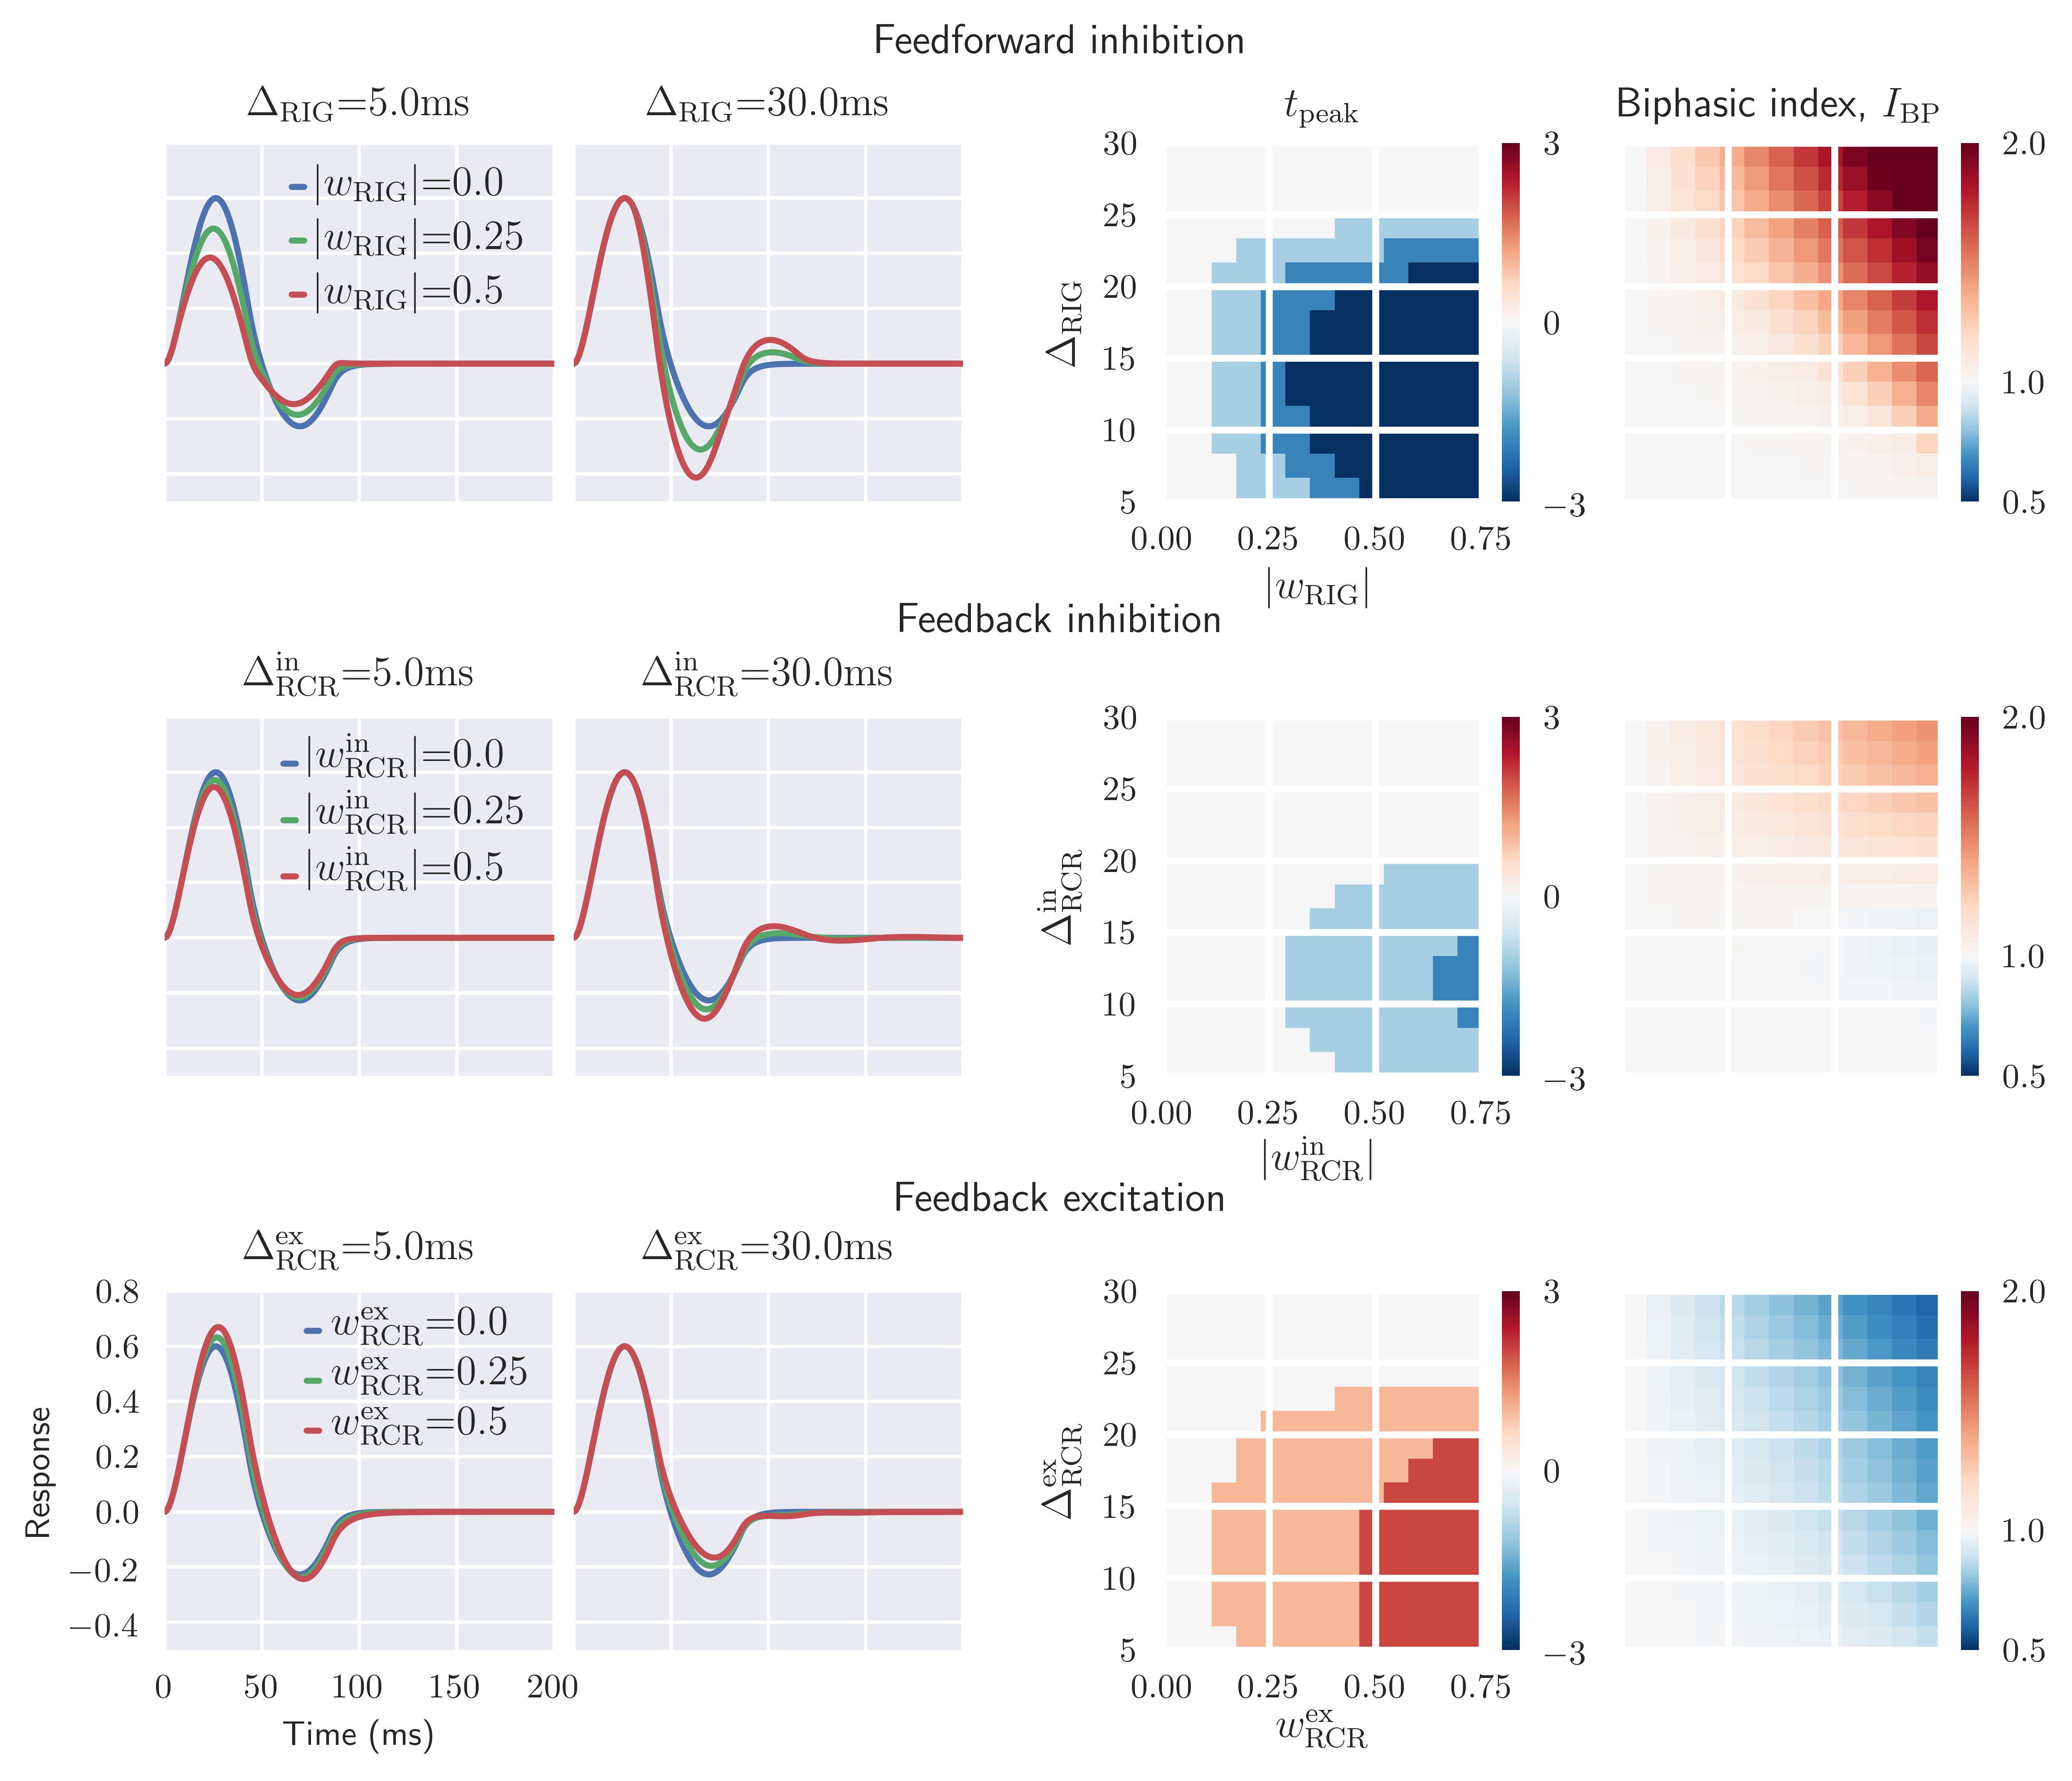

In [8]:
cmap = "RdBu_r"
interpolation = "None"
color = "gray"
alpha = 0.4

# labels, titles:
fig = plt.figure(figsize=(8, 8))
fig.text(0.5, 0.93, "Feedforward inhibition", ha='center', va='center', fontsize=12)
fig.text(0.5, 0.64, "Feedback inhibition", ha='center', va='center', fontsize=12)
fig.text(0.5, 0.35, "Feedback excitation", ha='center', va='center', fontsize=12)

w_labels = [r"$|w_\mathrm{RIG}|$", 
            r"$|w_\mathrm{RCR}^\mathrm{in}|$", 
            r"$w_\mathrm{RCR}^\mathrm{ex}$"]

delay_labels = [r"$\Delta_\mathrm{RIG}$", 
                r"$\Delta_\mathrm{RCR}^\mathrm{in}$", 
                r"$\Delta_\mathrm{RCR}^\mathrm{ex}$"]


# line plots:
t_max = 200
ymin = -0.5
ymax = 0.8
yticks = [-0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
xticks = [0, 50, 100, 150, 200]
weight_ticks = [0.0, 0.25, 0.5, 0.75]
times = network.integrator.times
w_ids = [0, np.where(weight==0.5)[0], np.where(weight==1.0)[0]]

# imshow plots:
t_peak_vmin = -3
t_peak_vmax = 3

I_bp_vmin = 0.5
I_bp_vmax = 2.0

# line plots
gs1 = gridspec.GridSpec(6, 2)
gs1.update(left=0.05, right=0.45, hspace=3, wspace=0.05)

ax_1 = plt.subplot(gs1[:2, 0])
ax_2 = plt.subplot(gs1[:2, 1])
ax_5 = plt.subplot(gs1[2:4, 0])
ax_6 = plt.subplot(gs1[2:4, 1])
ax_9 = plt.subplot(gs1[4:6, 0])
ax_10 = plt.subplot(gs1[4:6, 1])

# imshow plots
gs2 = gridspec.GridSpec(6, 2)
gs2.update(left=0.55, right=0.98, hspace=3, wspace=0.15)

ax_3 = plt.subplot(gs2[:2, 0])
ax_4 = plt.subplot(gs2[:2, 1])
ax_7 = plt.subplot(gs2[2:4, 0])
ax_8 = plt.subplot(gs2[2:4, 1])
ax_11 = plt.subplot(gs2[4:6, 0])
ax_12 = plt.subplot(gs2[4:6, 1])

axarr = ((ax_1, ax_2, ax_3, ax_4),
         (ax_5, ax_6, ax_7, ax_8),
         (ax_9, ax_10, ax_11, ax_12))

#########################################################################################################################
# create figure
#########################################################################################################################
ax_3.set_title(r"$t_\mathrm{peak}$", fontsize=12)
ax_4.set_title(r"Biphasic index, $I_\mathrm{BP}$")
ax_9.set_xlabel("Time (ms)")
ax_9.set_ylabel("Response")

for i, (w_label, delay_label, data, delay, w) in enumerate(zip(w_labels, delay_labels,
                                                               [irf_data["ff_in"], irf_data["fb_in"], irf_data["fb_ex"]],
                                                               [delay_rig, delay_rc_in, delay_rc_ex],
                                                               [abs(A_rig)*w_rig, abs(A_rc_in)*w_rc_in, A_rc_ex*w_rc_ex])):
   
    ax1, ax2, ax3, ax4 = axarr[i]
    
    # line plots
    for ax, delay_id in zip([ax1, ax2], [0, -1]):
        delay_magnitude = round(float(delay[delay_id].magnitude), 1)
        ax.set_title(delay_label+r"${{=}}{}\mathrm{{ms}}$".format(delay_magnitude))
        ax.set_ylim([ymin, ymax])
        ax.set_xlim([0, t_max])
        ax.set_yticks(yticks)
        ax.set_xticks(xticks)
        
        for w_id in w_ids:
            w_magnitude = round(float(w[w_id]), 2) 
            ax.plot(times, data["irf"][:, delay_id, w_id],
                    label=w_label+r"$\mathord{{=}}{}$".format(w_magnitude))

    
    ax1.legend(fontsize=12, handlelength=0.3, labelspacing=0.3, borderpad=0.3, 
             borderaxespad=0.3, handletextpad=0.3, loc="upper right")
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if not ax1 == ax_9:
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    
    # t_peak plot
    extent = [float(w.min()), float(w.max()), float(delay.min().magnitude), float(delay.max().magnitude)]
    t_peak = (data["t_peak"].rescale("ms") - irf_data["ff_ex"]["t_peak"]).magnitude
    im1 = ax3.imshow(t_peak, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=t_peak_vmin, vmax=t_peak_vmax, 
                     norm=MidpointNormalize(midpoint=0.))
    
    plt.colorbar(im1, ax=ax3, ticks=[t_peak_vmin, 0, t_peak_vmax])
    ax3.grid(color="w", lw=2)  
    ax3.set_ylabel(delay_label, fontsize=12)
    ax3.set_xlabel(w_label, fontsize=12)
    ax3.set_xticks(weight_ticks)

    
    # Biphasic index plot
    I_bp = data["I_bp"] / irf_data["ff_ex"]["I_bp"]
    im2 = ax4.imshow(I_bp, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=I_bp_vmin, vmax=I_bp_vmax, 
                     norm=MidpointNormalize(midpoint=1.))
    
    plt.colorbar(im2, ax=ax4, ticks=[I_bp_vmin, 1, I_bp_vmax])
    ax4.set_xticks(weight_ticks)
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.grid(color="w", lw=2)  